In [94]:
%matplotlib inline  
import pandas as pd #data manipulation
import numpy as np #numerical calculations
import matplotlib.pyplot as plt #plot
import yfinance as yf  #幫我們抓取分析資料
import datetime #時間套件
from sklearn.linear_model import LinearRegression
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn' 
#!pip install yfinance  
#!pip install datetime  

##自由發揮題：應用線性回歸預測股票價格

* 目的：希望使用線性迴歸模型，對股票做簡單的趨勢預測！

* 標的：台積電(2330.TW)，日資料

* 資料區間：2020/01/01-2022/01/01  
* 資料來源：Yahoo Finance

* 撰寫思路：  
第一步，運用Yahoo Finance抓取股價資料。  
第二步，對股票資料做探索式資料分析(EDA)。  
第三步，使用sklearn套件來做線性迴歸模型的訓練和預測


### 第一步，運用Yahoo Finance抓取股價資料。

In [90]:
#get data
tick = '2330.TW'
stock = yf.download(tick,
                start=datetime.datetime(2020, 1, 1),
                end=datetime.datetime(2022, 1, 1))
stock.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


### 第二步，對股票資料做探索式資料分析(EDA)。

In [55]:
stock.head() #前五筆資料

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,332.5,339.0,332.5,339.0,320.628021,31754120
2020-01-03,344.0,345.0,335.5,339.5,321.100983,41811268
2020-01-06,333.0,334.5,332.0,332.0,314.007477,45343057
2020-01-07,332.5,333.0,326.5,329.5,311.642883,50879181
2020-01-08,325.0,333.0,325.0,329.5,311.642883,37567748


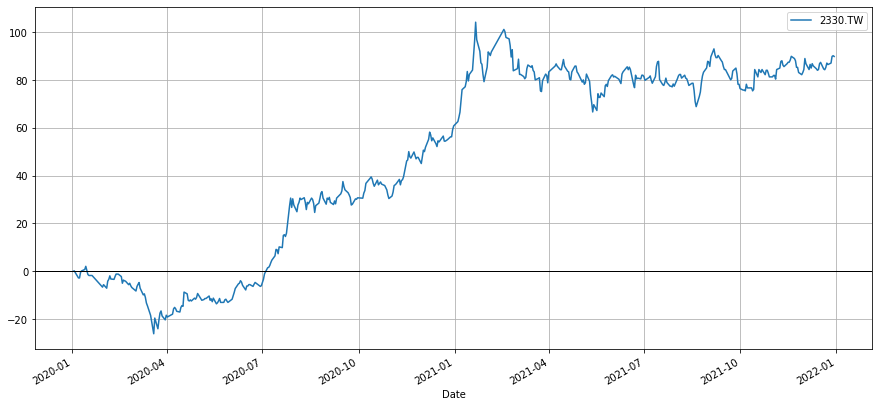

In [92]:
#累積報酬率 
cum_return = pd.DataFrame(stock['Adj Close']).apply(lambda x: (x / x[0]-1)*100)
cum_return.columns = [tick]
cum_return.plot(figsize=(15,7),grid = True).axhline(y = 0, color = "black", lw = 1)

Text(0, 0.5, 'Probability density')

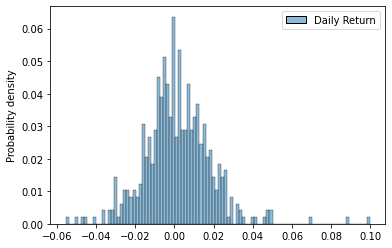

In [31]:
##算日報酬率
daily_return = pd.DataFrame(stock['Adj Close']).apply(lambda x: (x / x.shift(1))-1)
daily_return.columns = ['Daily Return']
daily_return.dropna(inplace=True)
#畫出日報酬率的機率密度函數圖，了解一下分布情況。
plt.figure()  
sns.histplot(daily_return,bins = 100,stat='probability')
plt.ylabel('Probability density')

In [32]:
#基本統計分析 - 日報酬率
daily_return.describe() 

,Daily Return
count,487.000000
mean,0.001460
std,0.017015
min,-0.055556
25%,-0.008418
50%,0.000000
75%,0.011379
max,0.099741


### 第三步，使用sklearn套件來做線性迴歸模型的訓練和預測

開始訓練之前，要特別注意股價資料使用上，我們應該是只能拿前一天或歷史的股價資訊，來預測當下或是未來的股價。因此，我們這邊就不使用train_test_split( )函數，因為此函數是用來**隨機劃分**樣本數據成訓練集和測試集；而這有可能落入時間的謬誤裡面！（意即提前使用未來的資料）。


#### 首先我們先將要用來訓練、測試的 X, y 準備好，這邊我們用 80% 做訓練期，20%做測試期

In [37]:
def train_test_split(data,train_period = 0.8 ,train_or_test = True): # get train data: train_or_test=True, else: train_or_test=False
    if train_or_test == True:
        length = len(data.index)      
        tlength =int(length*train_period)  
        traindata = data.head(tlength)
        return traindata
        
    elif train_or_test == False:
        test_period = - train_period
        length2 = len(data.index)     
        tlength2 =int(length2*test_period)  
  
        testdata = data.tail(tlength2)

        return testdata

In [93]:
train = train_test_split(stock) #train data
test = train_test_split(stock,train_or_test = False) #test data
time_split = stock.index[len(train)]
#test data
X_train = train[['Open','High','Low','Volume']] #features
y_train = train['Adj Close'].values.reshape(-1,1) #target
#train data
X_test = test[['Open','High','Low','Volume']]
y_test = test['Adj Close'].values.reshape(-1,1)

#### 再來建立線性迴歸模型，並且訓練模型，預測未來股價！

In [58]:
# 建立線性迴歸模型
regr = LinearRegression()
#訓練模型
regr.fit(X_train, y_train)

#將訓練好的模型，用來做預測
trainings = regr.predict(X_train).reshape(-1,1)
predictions = regr.predict(X_test).reshape(-1,1)

### 將預測結果合在一起
all_pred = np.concatenate((trainings, predictions), axis=0)

### 計算方均根差
train_rmse = np.sqrt(1/X_train.shape[0]*np.squeeze(np.dot((trainings - y_train).T, (trainings - y_train))))
test_rmse = np.sqrt(1/X_test.shape[0]*np.squeeze(np.dot((predictions - y_test).T, (predictions - y_test))))

#評估模型好壞
print("Training RMSE is: %f" % train_rmse)
print("Testing RMSE is: %f" % test_rmse)

Training RMSE is: 3.638333
Testing RMSE is: 5.639662


RMSE可以評價數據的變化程度，RMSE的值越小，說明預測模型描述實驗數據具有更好的精確度。  
可以看到訓練資料的方均根差大約是3.64，而測試資料的方均根差偏高約是5.64。

#### 最後，將模型訓練結果作圖，看看效果如何。

In [77]:
# 將預測和真實的股價，放進 df_linear 以便做圖
df_linear = pd.DataFrame(all_pred, columns=['Linear Adj Close'], index=stock.index)
df_linear['Adj Close'] = stock['Adj Close']
 

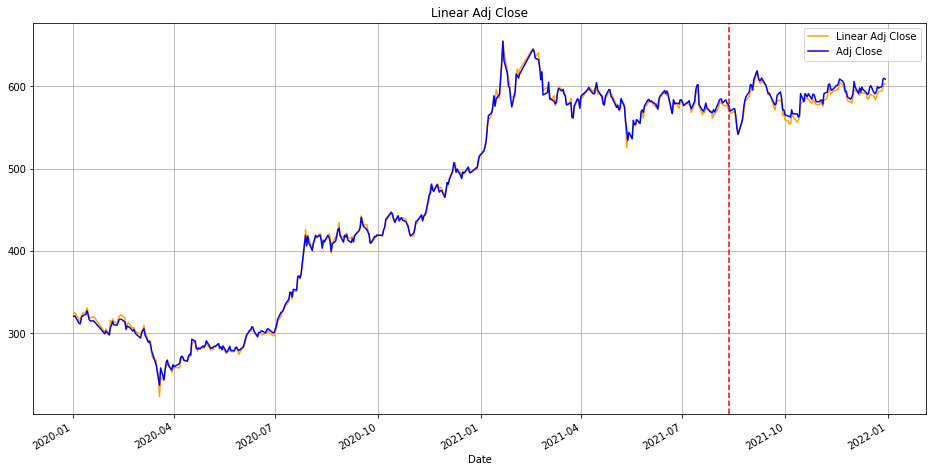

In [89]:
# 畫出結果
df_linear.plot(figsize=(16,8), title='Linear Adj Close', grid=True, legend=True, color=['orange','blue'])
plt.axvline(pd.Timestamp(time_split),linestyle ='--',color='r')

從圖上可以看到，橘色線是我們線性迴歸模型預測的結果。
在紅色直線時間點之前，是有參與訓練的資料，看起來和真實資料藍色線較為靠近。
而紅色直線時間點之後，是完全沒參與訓練，只用來做測試的資料，雖然較為偏離藍色線，但是可以觀察到趨勢竟然跟真實股價還蠻接近的。
* 註：在預測時沒有考慮到漲跌停的因素，所以我們可以發現預測結果的漲跌幅度比真實數據要大。